# This is code for running Xgboost on TCGA RNAseq data

An example file is included for the stomach (STAD) dataset in the TCGA. The file is pre-labelled with a tag for file type (if you are unsure how to do this yourself, see: https://wiki.nci.nih.gov/display/TCGA/TCGA+barcode)

This code generates a model, then plots some output, significantly more complex things can be done with the results, but this is a taster to show how the feature weights and gains from the paper were generated.

Note - the results from this particular analysis of the STAD dataset are likely not very useful, as the data contains an extremely small number of normal samples for model generation.

## Preamble and setup

In [6]:
# load libraries
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import sys
from sklearn import cross_validation
import numpy
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib

## Catch warnings to avoid clogging the notebook with depreciation messages ##
import warnings
warnings.simplefilter("ignore")

In [7]:
# set figure size
matplotlib.rcParams["figure.figsize"] = (10, 7)

In [8]:
# module for generating F1 score
def xgb_f1(y,t):
    t = t.get_label()
    y_bin = [1. if y_cont > 0.5 else 0. for y_cont in y] # binaryzing your output
    return 'f1',f1_score(t,y_bin)

## Read in comma-delimited file

In [9]:
# reads a matrix of expression data (.csv)
inputfile = "./STAD_only.csv"

## Do some preprocessing

In [10]:
# import data
data = pd.read_csv(inputfile, index_col=0)

# transpose
dataflip = pd.DataFrame.transpose(data)

# convert column 0 name to "type"
dataflip.columns.values[0]="type"

# convert type column to binary
dataflip['type'] = (dataflip['type'] !='tumor').astype(int)

# convert data to numeric format
num_dataflip = dataflip.apply(pd.to_numeric)

## Set up and generate model

In [11]:
# split data
Y = num_dataflip['type']
X = num_dataflip.drop(["type"],axis=1)

# set up test set
test_size = 0.20

# generate cross-validated subsets of data
X_train_train, X_train_valid, y_train_train, y_train_valid = cross_validation.train_test_split(X, Y, test_size = test_size)
eval_set = [(X_train_valid, y_train_valid)]

# build model (these parameters were optimized through paramaeter searching)
model = XGBClassifier(max_depth = 7, n_estimators = 400, learning_rate=0.1, missing=0)
model.fit(X_train_train, y_train_train, eval_metric="error", early_stopping_rounds=40, eval_set = eval_set, verbose = True)

[0]	validation_0-error:0.036585
Will train until validation_0-error hasn't improved in 40 rounds.
[1]	validation_0-error:0.036585
[2]	validation_0-error:0.036585
[3]	validation_0-error:0.036585
[4]	validation_0-error:0.036585
[5]	validation_0-error:0.060976
[6]	validation_0-error:0.036585
[7]	validation_0-error:0.036585
[8]	validation_0-error:0.060976
[9]	validation_0-error:0.036585
[10]	validation_0-error:0.036585
[11]	validation_0-error:0.036585
[12]	validation_0-error:0.02439
[13]	validation_0-error:0.02439
[14]	validation_0-error:0.02439
[15]	validation_0-error:0.02439
[16]	validation_0-error:0.02439
[17]	validation_0-error:0.02439
[18]	validation_0-error:0.02439
[19]	validation_0-error:0.02439
[20]	validation_0-error:0.02439
[21]	validation_0-error:0.02439
[22]	validation_0-error:0.02439
[23]	validation_0-error:0.02439
[24]	validation_0-error:0.02439
[25]	validation_0-error:0.02439
[26]	validation_0-error:0.02439
[27]	validation_0-error:0.02439
[28]	validation_0-error:0.02439
[29]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=0, n_estimators=400,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

## Test the model

In [12]:
# testing
y_pred_test = model.predict(X_train_valid)
predictions = [round(value) for value in y_pred_test]

# generate overall accuracy score
accuracy = accuracy_score(y_train_valid, predictions)
print("Accuracy on testing: %.2f%%" % (accuracy * 100.0))

Testset = y_train_valid.as_matrix()
zipped = numpy.dstack((Testset, predictions))

## calculate precision and recall (these can be used for generation of matthews correlation coefficients)
for item in zipped:
     falsepos = 0
     falseneg = 0
     match = 0
     
     for place in item:
         totalcount = len(item)
         if (place[0] == 0) & (place[1] == 1):
             falsepos += 1
         elif (place[0] == 1) & (place[1] == 0):
             falseneg += 1
         elif place[0] == place[1]:
             match += 1

for item in zipped:
    negcount = 0
    poscount = 0
    for place in item:
        if place[0] == 0:
            negcount += 1
        if place[0] == 1:
            poscount += 1

Accuracy on testing: 97.56%


In [13]:
# generate false positives and negatives
falseposp = (falsepos/negcount) * 100
falsenegp = (falseneg/poscount) * 100
totalp = (match/totalcount) * 100
print("False positives (Predicted cancer cell, is normal): %d out of %d" % (falsepos, negcount))
print("False negatives (Predicted normal cell, is cancer cell): %d out of %d" % (falseneg, poscount))
print("Correct matches: %d out of %d total" % (match, totalcount))
# Note that 1/3 of normal cells are misidentified - this is something that a Matthews Correlation Coefficient will punish
# but an F1 score will not (as much), as the MCC score takes sample size into account explicitly

False positives (Predicted cancer cell, is normal): 1 out of 79
False negatives (Predicted normal cell, is cancer cell): 1 out of 3
Correct matches: 80 out of 82 total


## Extraction of weights and gains

In [14]:
# get feature weights and gains
weightscore = model._Booster.get_score(importance_type = "weight")
gainscore = model._Booster.get_score(importance_type = "gain")

# put them into dataframes
weightframe = importance_frame = pd.DataFrame({'Importance': list(weightscore.values()), 'Feature': list(weightscore.keys())})
gainframe = importance_frame = pd.DataFrame({'Importance': list(gainscore.values()), 'Feature': list(gainscore.keys())})

# generate combination score
combined_importance = weightframe['Importance']*gainframe['Importance']
combinedframe = pd.concat([gainframe['Feature'],combined_importance], axis=1)

# sort by importance to find the most important genes
weightframe.sort_values(by = 'Importance', inplace = True, ascending = False)
gainframe.sort_values(by = 'Importance', inplace = True, ascending = False)
combinedframe.sort_values(by = 'Importance', inplace = True, ascending = False)

In [15]:
# look only at the top 25 genes in each case
weightframe_top = weightframe.head(25)
gainframe_top = gainframe.head(25)
combinedframe_top = combinedframe.head(25)

## Do some plotting of features

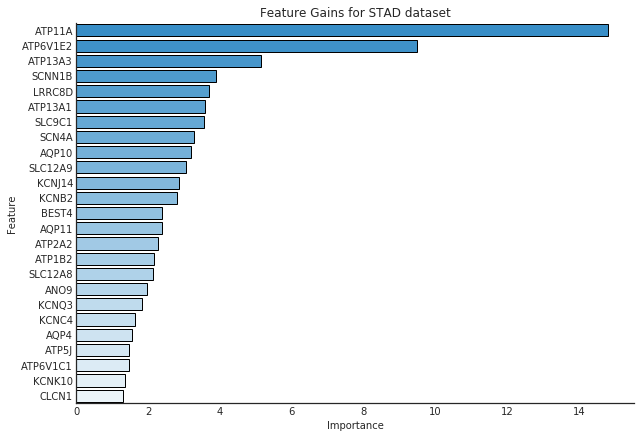

In [16]:
sns.set_style("white")
palette = sns.light_palette("#2093DF", n_colors=25, reverse = True)
sns.barplot(y= "Feature", x="Importance", data= gainframe_top, palette= palette, edgecolor = "k")
sns.despine()
plt.title("Feature Gains for STAD dataset")
plt.show()

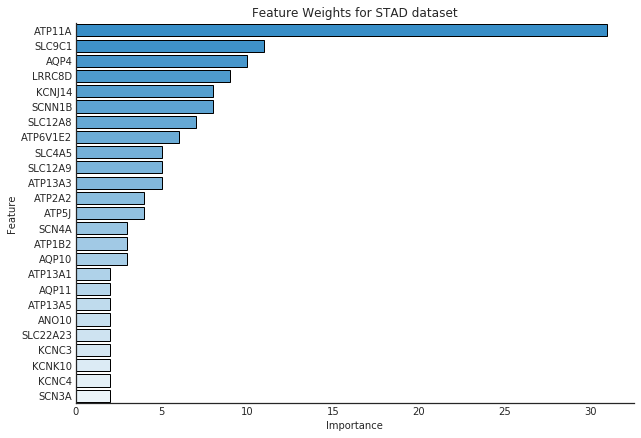

In [17]:
sns.barplot(y= "Feature", x="Importance", data= weightframe_top, palette= palette, edgecolor = "k")
plt.title("Feature Weights for STAD dataset")
sns.despine()
plt.show()

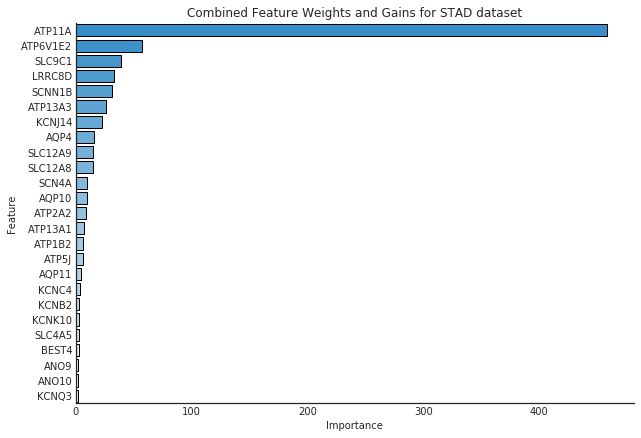

In [18]:
sns.barplot(y= "Feature", x="Importance", data= combinedframe_top, palette= palette, edgecolor = "k")
plt.title("Combined Feature Weights and Gains for STAD dataset")
sns.despine()
plt.show()

## Look at the expression of the top genes

In [19]:
# add importance values to original array
weight_combined = data.join(weightframe.set_index("Feature"))
weight_combined.sort_values(by = 'Importance', inplace = True, ascending = False)

# move some columns around (sorry for the hideous code practise)
weight_combined_flip = pd.DataFrame.transpose(weight_combined)
cols = list(weight_combined_flip)
cols.insert(0, cols.pop(cols.index('type')))
weight_combined_flip_transpose = weight_combined_flip.ix[:, cols]
weight_combined_flipback = pd.DataFrame.transpose(weight_combined_flip_transpose)

# take top 25 genes
top_alldata = weight_combined_flipback.head(26)

In [20]:
# do more horribly coded data transformation
top_alldata_flip = pd.DataFrame.transpose(top_alldata)

# convert type into binary
top_alldata_flip['type'] = (top_alldata_flip['type'] !='tumor').astype(int)

# take normal and tumor samples for the top 25 genes
top_tumor = top_alldata_flip[top_alldata_flip["type"] == 0]
top_normal = top_alldata_flip[top_alldata_flip["type"] == 1]

# calculate some meta data 
num_tumor = top_tumor.apply(pd.to_numeric)
summed_tumor = num_tumor.mean()
std_dev_tumor = num_tumor.std()

num_normal = top_normal.apply(pd.to_numeric)
summed_normal = num_normal.mean()
std_dev_normal = num_normal.std()

# have a look at the overall values for each gene
combined = pd.concat([summed_tumor, std_dev_tumor, summed_normal, std_dev_normal], axis = 1)
combined.columns = ["TUMOR_AVG", "TUMOR_STD", "NORMAL_AVG", "NORMAL_STD"]
combined.head()

,TUMOR_AVG,TUMOR_STD,NORMAL_AVG,NORMAL_STD
type,0.000000,0.000000,1.000000,0.000000
ATP11A,193.925536,153.386049,38.837778,13.707172
SLC9C1,0.800856,0.797018,0.569806,1.881385
AQP4,0.572361,2.567203,11.698225,21.798659
LRRC8D,37.688028,13.649619,17.314210,9.032058


Here is where you could do some more plotting and study your specific genes and their expression in more detail

# Plot some expression heatmaps

In [21]:
# define a random seed
seed = 98534

# take some random samplings from the data
tumor_sample = top_tumor.sample(25, random_state=seed)
normal_sample =  top_normal.sample(25, random_state=seed)

# massage the data into the format for heatmaps
smaller_array = pd.concat([tumor_sample, normal_sample])
heatmap_array = pd.DataFrame.transpose(smaller_array)
heatmap_num = heatmap_array.apply(pd.to_numeric)
heatmap_num = heatmap_num.drop(["Importance"], axis = 1)

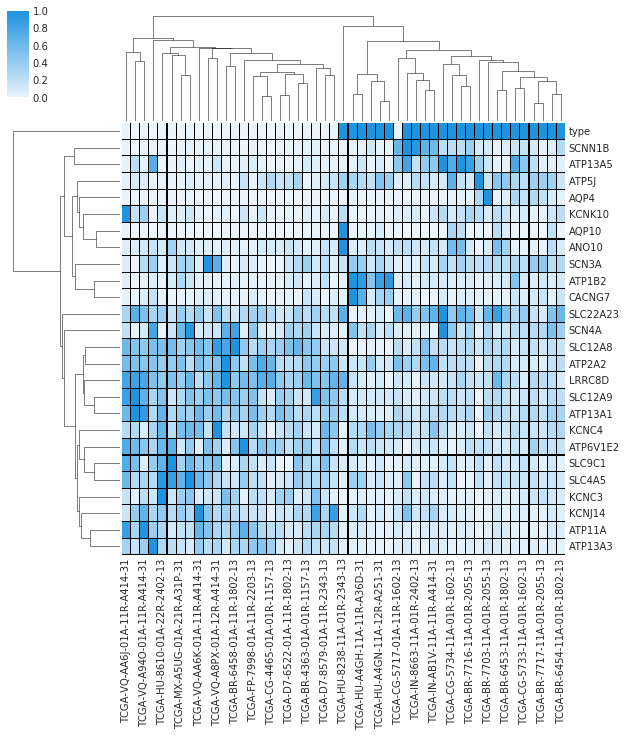

In [22]:
# generate 
palette_cmap = sns.light_palette("#2093DF", as_cmap = True)
g = sns.clustermap(heatmap_num, row_cluster=True, col_cluster=True, standard_scale=0,cmap = palette_cmap, lw =0.05, linecolor="k")
plt.show()

In [23]:
# Look at actual expression values
heatmap_num.head()

,TCGA-BR-7716-01A-21R-2055-13,TCGA-KB-A93H-01A-11R-A39E-31,TCGA-CG-5721-01A-11R-1602-13,TCGA-F1-6875-01A-11R-2055-13,TCGA-D7-8579-01A-11R-2343-13,TCGA-3M-AB47-01A-22R-A414-31,TCGA-D7-8578-01A-21R-2343-13,TCGA-VQ-A8PB-01A-11R-A39E-31,TCGA-VQ-AA6J-01A-11R-A414-31,TCGA-VQ-AA6K-01A-11R-A414-31,...,TCGA-BR-7716-11A-01R-2055-13,TCGA-HU-A4GH-11A-11R-A36D-31,TCGA-IP-7968-11A-01R-2203-13,TCGA-IN-AB1V-11A-11R-A414-31,TCGA-CG-5733-11A-01R-1602-13,TCGA-BR-7703-11A-01R-2055-13,TCGA-BR-7717-11A-01R-2055-13,TCGA-FP-7829-11A-01R-2055-13,TCGA-CG-5720-11A-01R-1602-13,TCGA-BR-6454-11A-01R-1802-13
type,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
ATP11A,143.723301,328.168665,123.450022,246.878986,162.267077,56.118953,149.994072,140.926758,413.455166,312.178048,...,42.182912,60.806702,50.644767,57.410225,26.002007,34.533728,21.510902,32.701595,58.432195,40.244804
SLC9C1,0.101127,0.753290,0.017928,1.183922,1.257109,1.200669,0.617387,0.207364,1.827217,0.957150,...,0.176096,0.201069,0.159763,0.143754,0.474922,0.101682,0.102433,0.083716,0.311865,0.086548
AQP4,0.258435,0.000000,0.000000,0.015578,0.128568,0.032895,0.138912,0.000000,0.073509,0.014725,...,1.344730,1.575043,0.978546,0.392057,20.401879,107.236315,23.013251,0.753445,9.611118,3.202275
LRRC8D,68.327840,42.472275,33.686115,34.972446,36.556163,30.477262,38.941659,50.274207,56.811756,21.646308,...,19.194425,12.617098,17.474042,15.146472,12.130312,19.281438,21.715768,9.648279,20.016075,13.090380
